In [10]:
import os
import pandas as pd
import sys
import multiprocessing as mp
import numpy as np
from functools import partial
import sox

from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import rc

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import scipy.stats

from ChildProject.projects import ChildProject

rc('text', usetex = True)
os.chdir("/Users/acristia/Documents/Lucas/metrics/solomon")

project = ChildProject(".")
project.read()

def get_error_rates(all_stats):
    grouped = all_stats.groupby(['child_id', 'date_iso', 'speaker_type'])
    df = grouped.agg({
        'cum_dur': ['std', 'mean', 'count'],
        'voc_count': ['std', 'mean', 'count'],
        'turns': ['std', 'mean', 'count'],
        'cds_dur': ['std', 'mean', 'count'],
        'min_duration': 'min'
    })
    df = df[df['cum_dur']['count'] >= 2]
    df = df[df['min_duration']['min'] >= 3600]

    for metric in ['cum_dur', 'voc_count', 'turns', 'cds_dur']:
        df[metric + '_err'] = df[metric]['std']/df[metric]['mean']

    df = df.reset_index()
    
    return df

def error_rates_boxplot(error_rates, metric):
    error_rates[['speaker_type', metric + '_err']].groupby('speaker_type').boxplot(column = [metric + '_err'], return_type = 'axes')
    
def error_rates_hist(error_rates, metric):
    subplots = error_rates[['speaker_type', metric + '_err']].hist(by = 'speaker_type', bins = 100, histtype = 'step')
    for ax in np.ndarray.flatten(subplots):
        ax.set_xlim(0, 1)
        ax.set_xlabel("$\\varepsilon_i$")
    
def plot_correlation(all_stats, metric):
    scatter = all_stats[['speaker_type', 'child_id', 'date_iso', metric]].groupby(['speaker_type', 'child_id', 'date_iso'])[metric].apply(lambda x: x.tolist())
    scatter = pd.DataFrame(scatter.tolist(), index=scatter.index)\
           .rename(columns=lambda x: x + 1)\
           .add_prefix('err')\
           .reset_index()
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(scatter['err1'].tolist(), scatter['err2'].tolist())

    fig, ax = plt.subplots(figsize=(8,6))
    u, scatter['label_num'] = np.unique(scatter['speaker_type'], return_inverse=True)
    sc = ax.scatter(x = 'err1', y = 'err2', c = 'label_num', data = scatter, marker = '+')

    x = np.linspace(0, 100000, 2)
    y = x
    ax.plot(x, y, color = 'black', linestyle = 'dashed')

    ax.legend(sc.legend_elements()[0], u, title = 'speaker\\_type')
    ax.set_xlim(0, max(scatter['err1'].max(), scatter['err2'].max()))
    ax.set_ylim(0, max(scatter['err1'].max(), scatter['err2'].max()))
    ax.set_xlabel(metric.replace('_', '\\_') + ' (recording 1)')
    ax.set_ylabel(metric.replace('_', '\\_') + ' (recording 2)')
    
    fig.text(0.8, 0.2, "$R^2 = $ {:.3f}".format(r_value**2))


# Voice type classifier stability on day-long recordings

## Summary

The voice type classifier labels portions of audio according to detected speaker types among MAL (male adult), FEM (female adult), CHI (key child), OCH (other child). 

The following metrics are derived from these labels for each speaker type :

 - `voc_count`, the count of vocalizations
 - `cum_dur`, the cumulative duration of vocalizations
 - `turns`, the amount of transitions between adult and key child speech
 - `cds_dur`, the cumulative duration of key child directed speech
 
In the Solomon dataset, children wore two recording devices at once, providing two audio files for each child. We expect the statistics for both these audio files to be nearly identical. They might differ slightly because of the noise introduced by the recording device, or because of the spatial distance between the two recorders. Ideally, the voice type classifier should be robust again this kind of noise. Derived metrics should not depend on the positioning of the recorder, nor on the device that was used.

To assert that, we compare the metrics derived for each pair of recordings for the solomon dataset. We find them to be stable down to a few percents, only after filtering out inconsistent pairs of recordings.

## Definitions

For a given metric $m$, let $m_i^1$ and $m_i^2$ be their respective values for the recordings 1 and 2 of the $i$-th pair. We define the relative error $\varepsilon_i$ as :

$$\varepsilon_i = \dfrac{|m_i^1-m_i^2|}{(m_i^1+m_i^2)/2}$$

Since the audios have different lengths $\tau_i^1$ and  $\tau_i^2$, we restrict our analysis to the segments $[0,\min(\tau_i^1,\tau_i^2)]$. These segments lasts several hours, so the shift between each audio among each pair can be neglected.


## Results

The results are shown below for $m$ = `cum_dur`.

              count      mean       50%       68%       95%       std
speaker_type                                                         
CHI           174.0  0.063700  0.023194  0.043716  0.224472  0.155450
FEM           175.0  0.079168  0.030941  0.053603  0.290948  0.152990
MAL           175.0  0.088230  0.036786  0.080242  0.309397  0.155448
OCH           175.0  0.075654  0.023260  0.039303  0.292896  0.195975


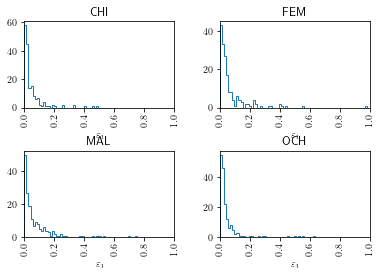

In [11]:
all_stats = pd.read_csv('output/all_stats.csv')
df = get_error_rates(all_stats)

metric = 'cum_dur'
print(df.groupby('speaker_type')[metric + '_err'].describe(percentiles=[0.5, 0.68, 0.95])[['count','mean','50%','68%','95%','std']])

error_rates_hist(df, 'cum_dur')

Although most error rates are lower than 10 %, the distribution of $\varepsilon$ has a large tail. Error rates in the tail (greater than a 10 \%) cannot be explained by noise.
Instead, we believe this is caused by mismatching pair of audios. This could happen if one of the recorder stops recording for a while before resuming. In this case, our understanding is that the USB recorder will produce several audio files that are later merged. The resulting recording might have very long gaps.

In order to test this hypothesis, we calculate the shift between both audios of each pair at every hour, calculating their cross-correlation in 5 minute blocks. Let $s_{ij}$ be the shift between the audios of the $i$-th pair at the $j$-th hour. We exclude all pairs such that $\sigma(s)_i$, the standard deviation of $(s_{ij})$ for a fixed i, is higher than a certain threshold (2 seconds, a little higher than the observed audio drift of the records).

This excludes all pairs of audios that do not perfectly match during their whole duration, amounting to 50 out of 175.
We obtain the following results :



              count      mean       50%       68%       95%       std
speaker_type                                                         
CHI           125.0  0.026452  0.017607  0.025747  0.072679  0.035656
FEM           125.0  0.044293  0.027074  0.039385  0.140023  0.067992
MAL           125.0  0.056949  0.026721  0.052745  0.188069  0.080794
OCH           125.0  0.032443  0.019181  0.030205  0.088915  0.053319


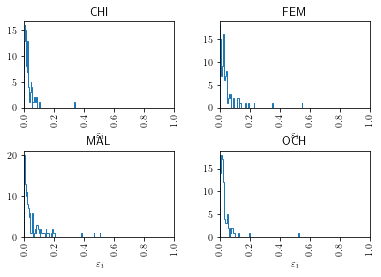

In [12]:
all_stats = pd.read_csv('output/all_stats.csv')

# exclude all recordings that have undergone merges
# undergone_merge = pd.read_csv('metadata/merged.csv')
# undergone_merge['recording'] = undergone_merge['filename'].str.extract(r"([0-9]+_(?:CW[0-9]+|NA)_CH[0-9]+_(?:AJ|FB|LM)[0-9]+_(?:AJ|FB|LM)[0-9]+_[0-9]{6})_") + '.WAV'
# undergone_merge.dropna(inplace = True)
# all_stats = all_stats[~all_stats['filename'].isin(undergone_merge['recording'].unique())]

# exclude all recordings with unstable shifts (i.e. audios don't seem to match)
shifts = pd.read_csv('output/shifts.csv')
shifts = shifts.groupby(['filename_1', 'filename_2']).std().reset_index()
shifts = shifts[shifts['shift'] < 2]
all_stats = all_stats[(all_stats['filename'].isin(shifts['filename_1'].unique())) | (all_stats['filename'].isin(shifts['filename_2'].unique()))]

df = get_error_rates(all_stats)

metric = 'cum_dur'
print(df.groupby('speaker_type')[metric + '_err'].describe(percentiles=[0.5, 0.68, 0.95])[['count','mean','50%','68%','95%','std']])

error_rates_hist(df, 'cum_dur')

Error rates are significantly lower after removing blatantly mismatching audios. The median error rate on the cumulated speech duration for each speaker type range between 1,8 % and 2,7 %, which could be more plausibly explained by the voice type classifier sensitivity to noise.

Below, we sum up the results for each metric.

### vocalization counts

In [13]:
metric = 'voc_count'
print(df.groupby('speaker_type')[metric + '_err'].describe(percentiles=[0.5, 0.68, 0.95])[['count','mean','50%','68%','95%','std']])

              count      mean       50%       68%       95%       std
speaker_type                                                         
CHI           125.0  0.022782  0.014570  0.022524  0.055314  0.038044
FEM           125.0  0.036535  0.019079  0.031807  0.103932  0.062919
MAL           125.0  0.050722  0.023908  0.049198  0.150369  0.076229
OCH           125.0  0.025749  0.017119  0.022287  0.064879  0.053003


### turns

In [14]:
metric = 'turns'
print(df.groupby('speaker_type')[metric + '_err'].describe(percentiles=[0.5, 0.68, 0.95])[['count','mean','50%','68%','95%','std']])

              count      mean       50%       68%       95%       std
speaker_type                                                         
CHI           125.0  0.029950  0.018087  0.028508  0.086762  0.043092
FEM           125.0  0.052325  0.027851  0.050307  0.158301  0.069151
MAL           125.0  0.075432  0.052830  0.097686  0.219929  0.068665
OCH           125.0  0.028794  0.022389  0.029240  0.078504  0.037090


In [15]:
### child directed speech duration

In [16]:
metric = 'cds_dur'
print(df.groupby('speaker_type')[metric + '_err'].describe(percentiles=[0.5, 0.68, 0.95])[['count','mean','50%','68%','95%','std']])

              count      mean       50%       68%       95%       std
speaker_type                                                         
CHI           125.0  0.028781  0.017917  0.031634  0.080296  0.037387
FEM           125.0  0.063310  0.041962  0.057410  0.205011  0.077704
MAL           125.0  0.082833  0.056680  0.100865  0.214972  0.079105
OCH           125.0  0.037119  0.025117  0.036952  0.104570  0.045117


### Correlation plots

In order to assess that these error rates are sufficiently low compared to the the variance of the data, we compute the correlation plots for each derived metric and their associated $R^2$ value. 

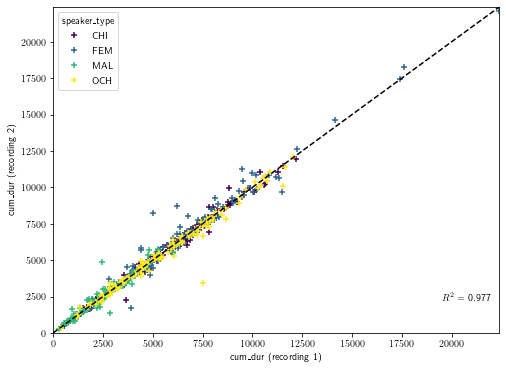

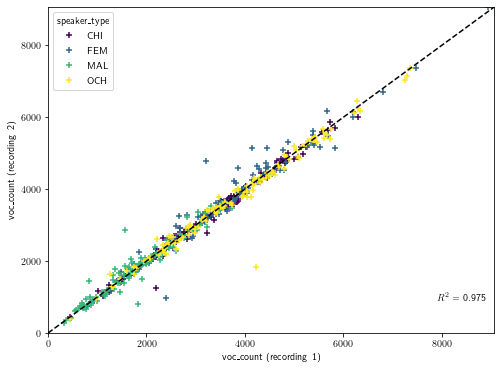

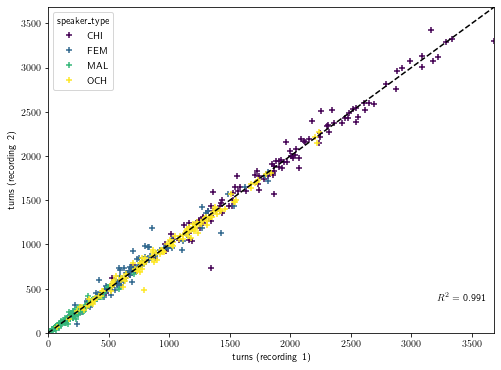

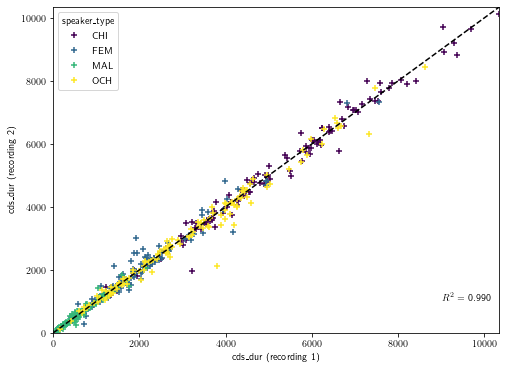

In [17]:
plot_correlation(all_stats, 'cum_dur')


In [ ]:
plot_correlation(all_stats, 'voc_count')

In [ ]:
plot_correlation(all_stats, 'turns')

In [ ]:
plot_correlation(all_stats, 'cds_dur')

$R^2$ are higher than 0,97, which confirms the robustness of the voice type classifier on our data.

## Conclusions

Derived metrics are consistent down to a few percents among pairs of recordings, once mismatching audios have been excluded. It is crucial to understand the cause of this mismatches (50 out of 175 pairs), as these files might not be suitable for our analyses. In the future, audio files featuring gaps or other potential issues should be flagged as such in the original dataset.